In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pixc2profile import download_pixc_data
from pixc2profile.river import River
from pixc2profile.pixc import PIXC
from pixc2profile.profile import Profile


/home/xinchenh/anaconda3/envs/pixc2profile/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# List all information below
home_dir = "/mnt/d/pixc2profile/examples/data"
river_name = "test_river"
start_date = "2025-08-01"
end_date = "2025-08-30"
# Assign SWOT pass and tile that cover the river reach
pass_tile_list = ["454_082L", "454_083L", "191_227L", "191_227R", "191_226R"]
pixc_version = "SWOT_L2_HR_PIXC_D"
# Set it as "interactive" if the netrc file is not configured
login_strategy = 'netrc'

# Step 1: Download PIXC data
pixc_file_paths = download_pixc_data(home_dir=home_dir,
                     pixc_version=pixc_version,
                   riv_name=river_name,
                   start_date=start_date,
                   end_date=end_date,
                   pass_tile_list=pass_tile_list,
                   login_strategy=login_strategy)


QUEUEING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 2986.33it/s]
PROCESSING TASKS | : 100%|██████████| 2/2 [00:32<00:00, 16.07s/it]
COLLECTING RESULTS | : 100%|██████████| 2/2 [00:00<00:00, 22310.13it/s]
QUEUEING TASKS | : 100%|██████████| 2/2 [00:00<00:00, 1888.05it/s]
PROCESSING TASKS | : 100%|██████████| 2/2 [00:17<00:00,  8.96s/it]
COLLECTING RESULTS | : 100%|██████████| 2/2 [00:00<00:00, 46863.73it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2874.78it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:12<00:00, 12.08s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 24385.49it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2519.10it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:13<00:00, 13.34s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 31775.03it/s]
QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 2158.67it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:11<00:00, 11.65s/it]
COLLECTING RESULTS | : 100%|██████████| 1/

Downloaded 7 PIXC files to /mnt/d/pixc2profile/examples/data/test_river/SWOT_L2_HR_PIXC_D


/mnt/d/pixc2profile/pixc2profile/river.py:325: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


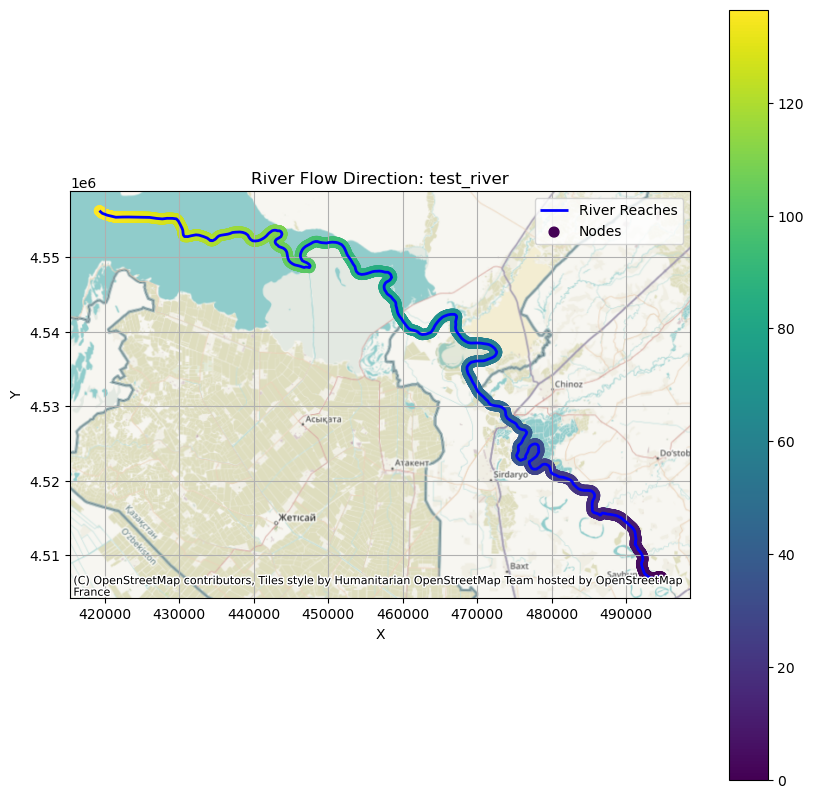

In [3]:
# Step 2: Create River object; Generate nodes and buffers
# make sure the river shapefile follows a correct topological order (from upstream to downstream)
river_shp_path = os.path.join(home_dir, "shps", "test_river.shp")
# create a node every 50 meters
node_spacing = 50 # m
# approximate river channel width for buffer generation
channel_width = 260 # m

# Initiate a river object
river = River(home_dir=home_dir,
              riv_name=river_name,
              riv_shp_path = river_shp_path,
              node_spacing = node_spacing,
              riv_width = channel_width,
              )
# generate node, create buffer, then export both shapefiles to "home_dir/river_name/nodes/"
# river.generate_nodes()
# river.generate_buffers()
# river.export_shapefiles()

# or just call process_river to do all above steps
river.process_river()

# plot streamwise distance to check if the nodes are correctly generated
river.plot_flow_direction()

# Step 3: Filter PIXC data within node buffers; remove non-water pixels; perform QC flags for removing poor-quality pixels

In [4]:
# Step 3: Create PIXC object; Extract PIXC data within buffers
pixc_water_dir_name="pixc_water"
pixc_qc_dirname="pixc_water_qc_filtered"
n_partitions = 10
classification_categories = [3, 4] # "water near land" and "open water"
prior_water_prob_threshold = 0.5 # Pekel et al. (2016)
water_frac_threshold = 0.2 # fraction of water
wse_upper_limit = 400 # m, upper limit of WSE to exclude outliers; Usually the elevation of river bank can be used here

# initiate PIXC object
pixc = PIXC(home_dir=home_dir,
              riv_name=river_name,
              pixc_file_paths=pixc_file_paths,
              var_list=None,
              create_ref_table_on_init=True)

# extract water pixels within buffers
pixc_water_paths = pixc.process_water_pixels(node_buffer_path=river.buffer_export_path,
                            pixc_water_dir_name=pixc_water_dir_name,
                            n_parts=n_partitions,
                            classification_categories=classification_categories,
                              prior_water_prob_threshold=prior_water_prob_threshold,
                              water_frac_threshold=water_frac_threshold,
                              dask_strategy = "dask-delay" # use "dask-geopandas" if RAM is limited; use "geopandas" if parallel computing is not needed
                          )
# data exported to "pixc_water/{date}_water.csv" under each river folder
print(pixc_water_paths)

# filter with quality flags
# here we show an example of filtering based on geolocation quality flags, removal pixels labeled with 4, 64, and 68
quality_flag_dict = {
    "geolocation_qual": [4, 64, 68]
}

pixc_water_qc_filtered_paths = pixc.filter_with_quality_flags(
      pixc_water_paths=pixc.pixc_water_paths,
      quality_flag_dict=quality_flag_dict,
      pixc_qc_dirname=pixc_qc_dirname
    )
# data exported to "pixc_water_qc_filtered/{date}_water_qc_filtered.csv" under each river folder
print(pixc_water_qc_filtered_paths)

Creating reference table from 7 PIXC files
Processing dates in parallel using Dask delayed...
[########################################] | 100% Completed | 16.42 s
['/mnt/d/pixc2profile/examples/data/test_river/pixc_water/20250805_water.csv', '/mnt/d/pixc2profile/examples/data/test_river/pixc_water/20250826_water.csv', '/mnt/d/pixc2profile/examples/data/test_river/pixc_water/20250817_water.csv']


Filtering PIXC water points with quality flags: 100%|██████████| 3/3 [00:00<00:00,  7.08it/s]

['/mnt/d/pixc2profile/examples/data/test_river/pixc_water_qc_filtered/20250805_water_qc_filtered.csv', '/mnt/d/pixc2profile/examples/data/test_river/pixc_water_qc_filtered/20250826_water_qc_filtered.csv', '/mnt/d/pixc2profile/examples/data/test_river/pixc_water_qc_filtered/20250817_water_qc_filtered.csv']


# Step 4: calculate median WSE for each buffer node to build WSE profile

In [5]:
output_path=os.path.join(home_dir, river_name, "profiles.csv")
profile_range=(0, np.inf) # if the profile needs to be cutted, change this parameter
agg_func = ["median", "std", "mean", "count"] # aggregation function to calculate WSE for each node; currently only support "median"
# keep quality flag values for the median calculation
keep_qual_groups=["interferogram_qual", "classification_qual", "geolocation_qual", "sig0_qual"]
# smooth parameters
frac_list=[0.01, 0.05, 0.1] # multiple LOWESS fractions to try
it=3 # number of iterations for LOWESS
seg_location = [47] # list of segment locations to apply different smoothing, e.g., [20, 30] to have three segments: 0-20km, 20-30km, 30-end


# Initiate Profile object for pixc water data
profile = Profile(home_dir=home_dir,
                riv_name=river_name,
                node_path=river.node_export_path,
                buffer_path=river.buffer_export_path,
                pixc_csv_paths=pixc_water_paths,
                output_path=None
                )
# build WSE profiles for all dates
wse_water = profile.build_wse_profiles_over_time(
                                    agg_func = agg_func,
                                    smooth_target = "wse_median",
                                    keep_qual_groups=keep_qual_groups,
                                    interpolation_method="lowess",
                                    seg_locations=seg_location,
                                    # interpolation params
                                    frac_list=frac_list,
                                    it=it,
                                    save_output=None,
                                    dask_strategy = "sequential"
                                    )
# Initiate another Profile object for pixc water qc filtered data
profile_qc = Profile(home_dir=home_dir,
                riv_name=river_name,
                node_path=river.node_export_path,
                buffer_path=river.buffer_export_path,
                pixc_csv_paths=pixc_water_qc_filtered_paths,
                output_path=None
                )
# build WSE profiles for all dates based on QC filtered data
wse_water_qc = profile_qc.build_wse_profiles_over_time(
                                    agg_func = agg_func,
                                    smooth_target = "wse_median",
                                    keep_qual_groups=keep_qual_groups,
                                    interpolation_method="lowess",
                                    seg_locations=seg_location,
                                    # interpolation params
                                    frac_list=frac_list,
                                    it=it,
                                    save_output=None,
                                    dask_strategy = "sequential"
                                    )

Building WSE profiles for 3 dates...


Processing dates: 100%|██████████| 3/3 [00:08<00:00,  2.77s/it]


Successfully processed all 3 dates
Successfully built profiles with 8199 records
Building WSE profiles for 3 dates...


Processing dates: 100%|██████████| 3/3 [00:07<00:00,  2.49s/it]

Successfully processed all 3 dates
Successfully built profiles with 8199 records


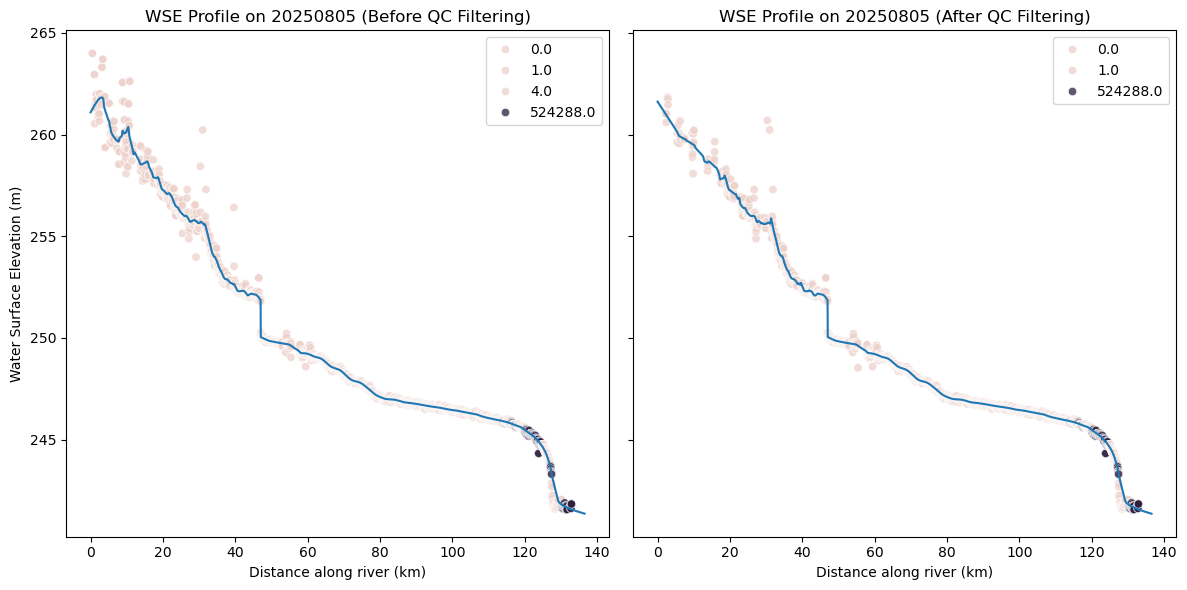

In [7]:
# plot comparison of WSE profiles before and after QC filtering for a specific date
date_to_plot = "20250805"
wse_water_date = wse_water[wse_water.date == date_to_plot]
wse_water_qc_date = wse_water_qc[wse_water_qc.date == date_to_plot]
smooth_var = "wse_median_lowess_0.05"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6), sharey=True)

sns.scatterplot(data=wse_water_date, x="dist_km", y="wse_median", ax=ax1, 
                alpha = 0.75, hue = "geolocation_qual")
sns.lineplot(data=wse_water_date, x="dist_km", y=smooth_var, ax=ax1)
sns.scatterplot(data=wse_water_qc_date, x="dist_km", y="wse_median", ax=ax2, 
                alpha = 0.75, hue = "geolocation_qual")
sns.lineplot(data=wse_water_qc_date, x="dist_km", y=smooth_var, ax=ax2)

# set titles and labels
ax1.set_title(f"WSE Profile on {date_to_plot} (Before QC Filtering)")
ax2.set_title(f"WSE Profile on {date_to_plot} (After QC Filtering)")
for ax in (ax1, ax2):
    ax.set_xlabel("Distance along river (km)")
    ax.set_ylabel("Water Surface Elevation (m)")
plt.tight_layout()
plt.show()
